In [ ]:
#IMPORTS
import sys
import json
from pathlib import Path
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#SET PROJECT FOLDER MAIN DIRECTORY
project_folder = Path.cwd().parent

#LOAD LOCAL_SETUP_CONFIG FILE
config_path = project_folder / "local_setup_config.json"
if config_path.exists():
    with open(config_path, "r", encoding="utf-8") as file:
        local_config  = json.load(file)
    print('Local configuration file loaded succesfully')
else:
    raise FileNotFoundError(f"Error: {config_path} not found")

# set run_local
run_local = local_config["run_local"]

In [ ]:
#MODULE PATHS
sys.path.append(str(project_folder))

In [ ]:
# MODULE IMPORTS
import load_database

In [ ]:
#LOAD DATABASE
load_database.load_db(project_folder)

<div align="center">
   <h1>ANÁLISIS EXPLORATORIO</h1>
</div>

A continuación se presentan algunos resultados del análisis exploratorio de la base de datos



In [ ]:
#DATABASE CONNECTION
if run_local:
    linkedindatabase_path = project_folder / "database" / "linkedindatabase.db"
else:
    linkedindatabase_path = project_folder / "linkedindatabase.db"

if linkedindatabase_path.exists():
    conn = sqlite3.connect(linkedindatabase_path)
    print("Opened database successfully")
else:
    raise FileNotFoundError(f"Error: {linkedindatabase_path} not found")

Opened database successfully


In [ ]:
#numerical data
df_num = pd.read_sql('SELECT * FROM clean_numerical_postings', conn)

df_num = df_num[df_num['max_salary'] <= 10000000]
df_num = df_num[df_num['min_salary'] <= 10000000]
df_num = df_num[df_num['normalized_salary'] <= 10000000]

df_num = df_num[df_num['max_salary'] > 100]
df_num = df_num[df_num['min_salary'] > 100]
df_num = df_num[df_num['normalized_salary'] > 100]

#postings
df_postings = pd.read_sql('SELECT * FROM postings', conn)

#companies
df_companies = pd.read_sql('SELECT * FROM companies', conn)

#industries
df_industries = pd.read_sql('SELECT * FROM industries', conn)

#job industries
df_job_industries = pd.read_sql('SELECT * FROM job_industries', conn)

#skills
df_skills = pd.read_sql('SELECT * FROM skills', conn)

#job skills
df_job_skills = pd.read_sql('SELECT * FROM job_skills', conn)

#company industries
df_company_industries = pd.read_sql('SELECT * FROM company_industries', conn)

In [50]:
#get job duration values
def get_duration(row):
    if pd.notna(row['closed_time']):
        return row['closed_time'] - row['listed_time']
    else:
        return None

df_num['duration'] = df_num.apply(get_duration, axis=1)
duration = df_num['duration'].dropna()

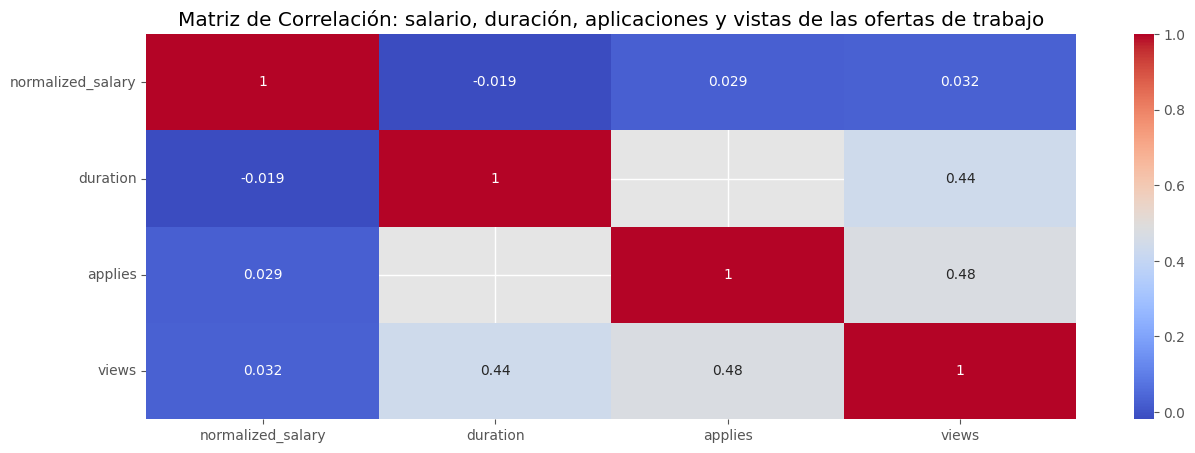

In [54]:


df_num_corr = df_num[['normalized_salary', 'duration', 'applies', 'views']]

plt.figure(figsize=(15,5))
sns.heatmap(df_num_corr.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')
plt.yticks(rotation=0)
plt.title('Matriz de Correlación: salario, duración, aplicaciones y vistas de las ofertas de trabajo')
plt.show()

## Compañías

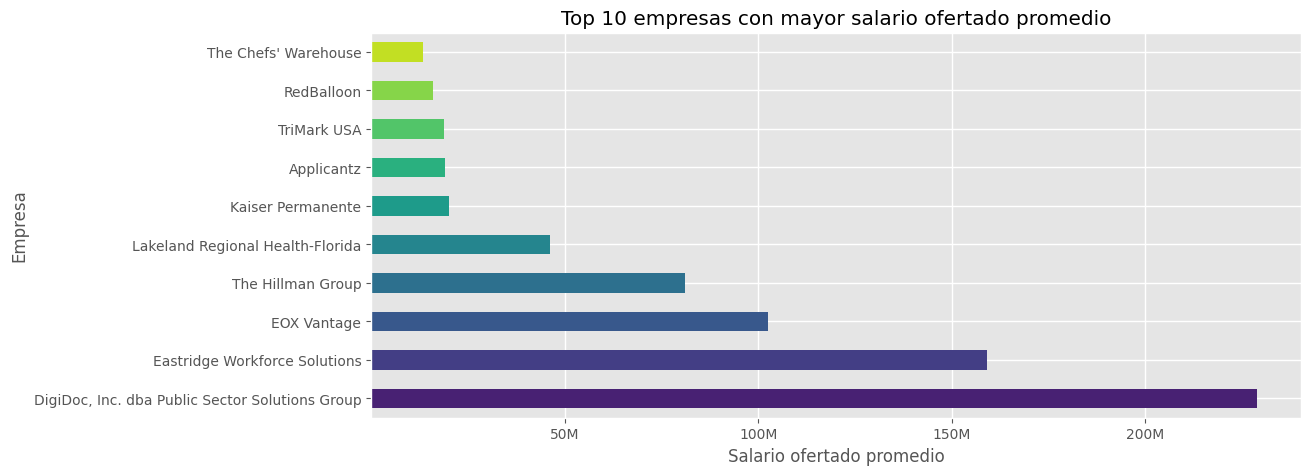

In [39]:
#top 10 companies with higher average salary
top_companies = df_postings.groupby('company_name')['normalized_salary'].apply(lambda x: np.mean(x)).nlargest(10)

# Define base colors (can be any color scheme)
base_colors = sns.color_palette('viridis', 10)

plt.figure(figsize=(12,5))
top_companies.plot(kind='barh', color=base_colors)
plt.xticks(ticks=np.arange(50000000, 240000000, 50000000), labels=[f'{int(i/1000000):,}M' for i in np.arange(50000000, 240000000, 50000000)])
plt.title('Top 10 empresas con mayor salario ofertado promedio')
plt.xlabel('Salario ofertado promedio')
plt.ylabel('Empresa')
plt.show()

DigiDoc, Inc. dba Public Sector Solutions Group ofrece los salarios más altos, superando los 200M.
Empresas como Eastridge Workforce Solutions y EOX Vantage también destacan con salarios elevados.
La disparidad en los salarios entre las empresas sugiere diferencias en industrias o tipos de cargos ofrecidos.

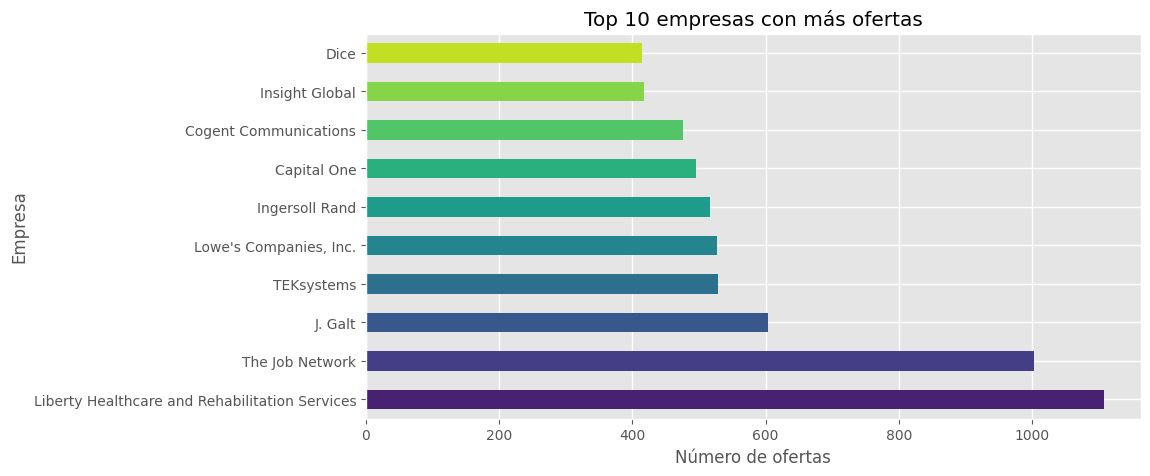

In [48]:
#top 10 companies with more job postings

top_companies_postings = df_postings['company_name'].value_counts().head(10)

# Define base colors (can be any color scheme)
base_colors = sns.color_palette('viridis', 10)

plt.figure(figsize=(10,5))
top_companies_postings.plot(kind='barh', color=base_colors)
plt.title('Top 10 empresas con más ofertas')
plt.ylabel('Empresa')
plt.xlabel('Número de ofertas')

plt.show()

Liberty Healthcare and Rehabilitation Services y The Job Network lideran en cantidad de ofertas de trabajo.
Empresas de tecnología y comunicaciones como TEKsystems y Insight Global tienen una presencia importante en el mercado laboral.
La cantidad de ofertas de empleo no necesariamente está relacionada con los salarios más altos.

## Industrias

industry
Staffing and Recruiting           2387
IT Services and IT Consulting     2130
Hospitals and Health Care         1673
Software Development              1440
Financial Services                 986
                                  ... 
Warehousing and Storage              2
Mobile Gaming Apps                   1
Wireless Services                    1
Strategic Management Services        1
Alternative Dispute Resolution       1
Name: count, Length: 144, dtype: int64


C:\Users\Sarah\AppData\Local\Temp\ipykernel_3592\3753779640.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_counts.head(10).index, y=industry_counts.head(10).values,palette=base_colors)


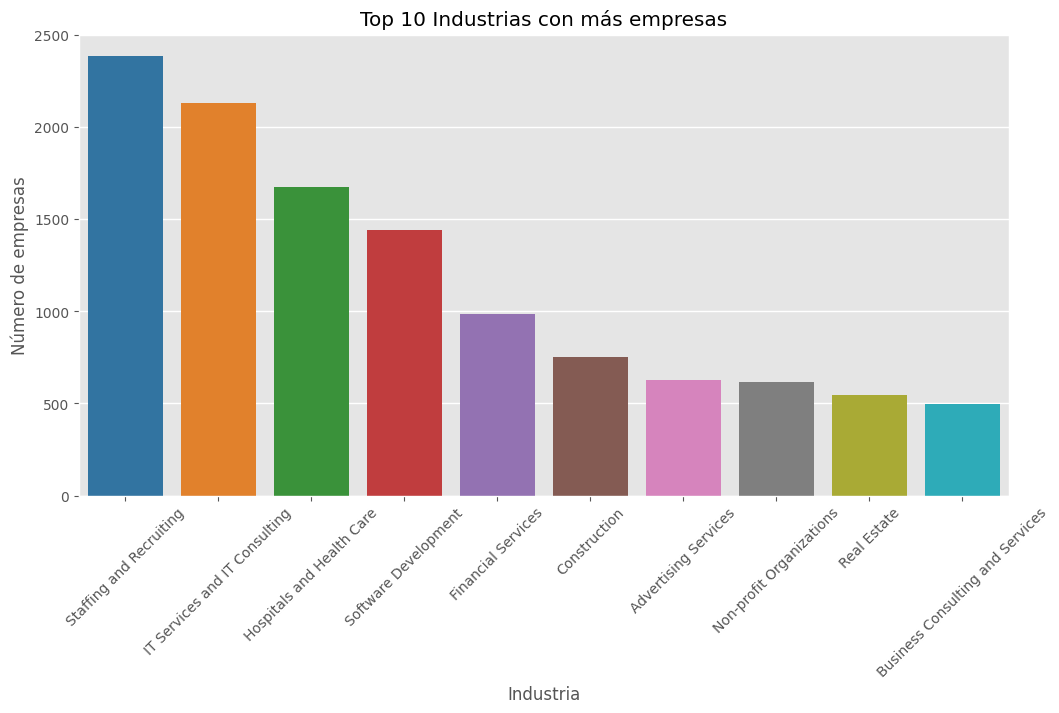

In [ ]:
industry_counts = df_company_industries['industry'].value_counts()

#Set colors
base_colors = sns.color_palette('tab10', 10)

plt.figure(figsize=(12,6))
sns.barplot(x=industry_counts.head(10).index, y=industry_counts.head(10).values,palette=base_colors)
plt.xticks(rotation=45)
plt.xlabel("Industria")
plt.ylabel("Número de empresas")
plt.title("Top 10 Industrias con más empresas")
plt.show()

## Habilidades

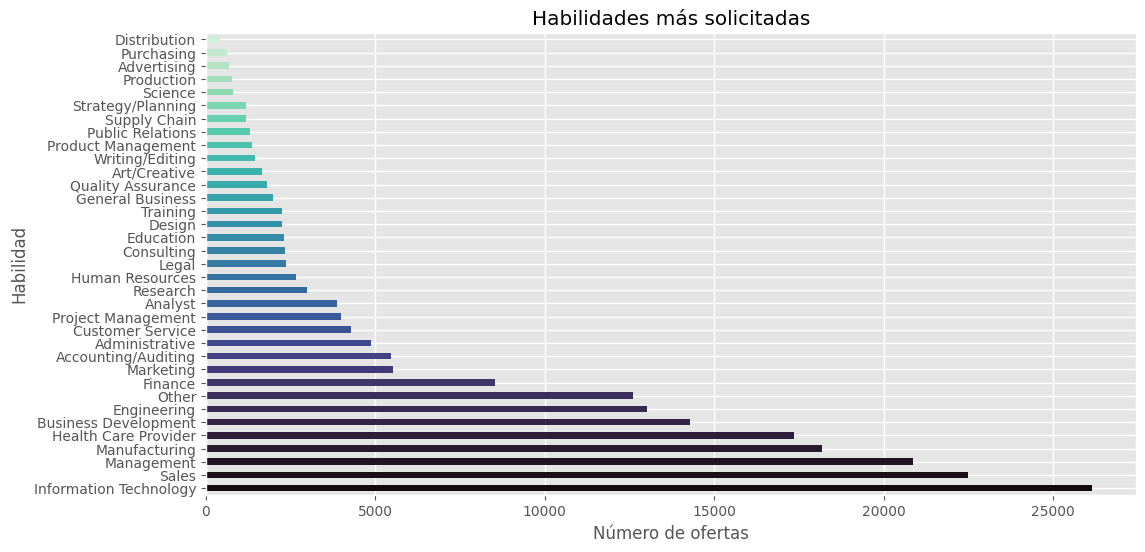

In [85]:
merged_df = pd.merge(df_job_skills, df_skills, left_on='skill_abr', right_on='skill_abr')

top_skills = merged_df['skill_name'].value_counts()#.head()

#Set colors
base_colors = sns.color_palette('mako', 35)

plt.figure(figsize=(12,6))
top_skills.head(35).plot(kind='barh', color=base_colors)
plt.ylabel("Habilidad")
plt.xlabel("Número de ofertas")
plt.title("Habilidades más solicitadas")

plt.show()

Las habilidades más demandadas son Tecnología de la Información, Ventas, Gestión, Manufactura y Desarrollo de Negocios, lo que indica una alta necesidad de profesionales en estas áreas.
Las habilidades relacionadas con ingeniería, finanzas y auditoría también tienen una gran demanda, lo que sugiere la importancia de habilidades técnicas y estratégicas en el mercado laboral.
Atención al cliente y administración aparecen en la mitad de la lista, lo que indica que son necesarias, pero no tan críticas como otras habilidades más especializadas.
Las habilidades menos solicitadas incluyen Distribución, Compras, Publicidad y Producción, lo que puede reflejar menor demanda o automatización de ciertas tareas en estos sectores.
Existe una diferencia considerable entre las habilidades más y menos solicitadas, lo que podría indicar que algunas áreas están saturadas mientras que otras tienen una escasez de talento

Text(0.5, 1.0, 'Salario promedio por habilidad')

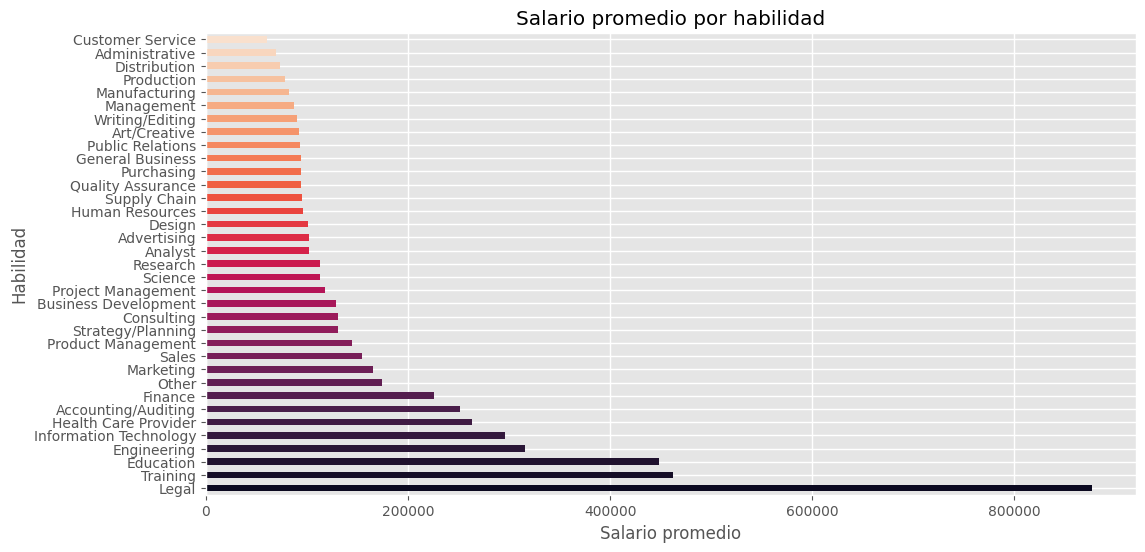

In [87]:
merged_df_salary = pd.merge(df_postings, merged_df, left_on='job_id', right_on='job_id')

top_skills_salary = merged_df_salary.groupby('skill_name')['normalized_salary'].apply(lambda x: np.mean(x)).nlargest(35)

#Set colors
base_colors = sns.color_palette('rocket', 35)

plt.figure(figsize=(12,6))
top_skills_salary.plot(kind='barh', color=base_colors)
plt.ylabel("Habilidad")
plt.xlabel("Salario promedio")
plt.title("Salario promedio por habilidad")

Las habilidades mejor remuneradas son las relacionadas con el área Legal, Training, Educación e Ingeniería, con salarios promedio significativamente más altos que el resto.
Habilidades técnicas y especializadas como Tecnología de la Información y Cuidado de la Salud también tienen salarios altos en comparación con otras áreas.
Habilidades en gestión y negocios, como Consultoría, Estrategia/Planificación, Gestión de Producto y Ventas, tienen salarios medianamente altos.
Las habilidades peor remuneradas incluyen Atención al Cliente, Administración y Producción, que tienen los salarios más bajos en la escala. Existe una brecha salarial considerable entre las habilidades mejor pagadas y las peor pagadas, lo que sugiere una diferencia en la demanda, especialización y formación requerida para cada área.

In [6]:
# Close connection
conn.close()